In [1]:
import os, math, json, random, time
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
AUTO = tf.data.experimental.AUTOTUNE
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.engine.topology import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


import numpy as np
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image

Using TensorFlow backend.


In [2]:
# Load the data
import pandas as pd 

data = pd.read_csv('combined_json_and_images.csv') 

# Preview the first 5 lines of the loaded data 
data.image[0]

'[[[ 95  69 108]\n  [135 109 136]\n  [124 103 112]\n  ...\n  [135  77  40]\n  [127  79  43]\n  [100  61  44]]\n\n [[171 145 154]\n  [227 205 208]\n  [235 217 213]\n  ...\n  [215 154  91]\n  [211 161 100]\n  [169 130  87]]\n\n [[170 152 132]\n  [253 238 219]\n  [255 254 238]\n  ...\n  [216 151  67]\n  [220 169  88]\n  [163 125  62]]\n\n ...\n\n [[ 76  56  58]\n  [ 51  26  29]\n  [ 48  18  20]\n  ...\n  [ 22  14  12]\n  [ 27  11  11]\n  [ 37  16  15]]\n\n [[ 44  29  32]\n  [ 31  16  21]\n  [ 35  19  22]\n  ...\n  [ 23  17  19]\n  [ 23  11  15]\n  [ 26  10  13]]\n\n [[ 27   5   7]\n  [ 24   5   7]\n  [ 25  13  15]\n  ...\n  [ 28  17  23]\n  [ 22   7  14]\n  [ 19   2  10]]]'

In [7]:
# Here's our 5 categories that we have to classify.
# class_names = ['inside', 'outside', 'food', 'drink', 'menu']
from sklearn.model_selection import train_test_split
class_names = ['drink', 'food', 'inside', 'menu', 'outside']
class_names_label = { 0:'drink',
                      1: 'food',
                      2: 'inside',
                      3: 'menu',
                      4: 'outside',
                    }
nb_classes = 5
x= data.drop(columns=['class_names_label'],axis=1)
y= data['class_names_label']
x_train_o, x_test_o, y_train , y_test  = train_test_split(x, y, test_size=0.20, random_state=42)

In [0]:
tpu = tf.contrib.cluster_resolver.TPUClusterResolver()

In [0]:
GCS_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec'
IMAGE_SIZE = [192, 192]

BATCH_SIZE = 128

VALIDATION_SPLIT = 0.19
CLASSES = ['drink', 'food', 'inside', 'menu', 'outside']

filenames = tf.gfile.Glob(GCS_PATTERN)
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
validation_steps = int(3670 // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(3670 // len(filenames) * len(training_filenames)) // BATCH_SIZE

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "class": tf.io.FixedLenFeature([], tf.int64),
        "one_hot_class": tf.io.VarLenFeature(tf.float32),
    }
    example = tf.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    class_label = tf.cast(example['class'], tf.int32)
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    one_hot_class = tf.reshape(one_hot_class, [5])
    return image, one_hot_class

def load_dataset(filenames):

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.Dataset.from_tensor_slices(filenames)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO) # faster
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

## training and validation datasets

In [0]:
def data_augment(image, one_hot_class):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0, 2)
    return image, one_hot_class# Plot a pie chart to check proporation of each observed category

sizes = np.bincount(y)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=None, labels=class_names,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Proportion of each observed category')

plt.show()

def get_batched_dataset(filenames, augment_data):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  dataset = dataset.repeat()
  if augment_data:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.prefetch(AUTO)
  return dataset

def get_training_dataset():
  return get_batched_dataset(training_filenames, augment_data=True)

def get_validation_dataset():
  return get_batched_dataset(validation_filenames, augment_data=False)

some_flowers, some_labels = dataset_to_numpy_util(load_dataset(validation_filenames), 8*20)

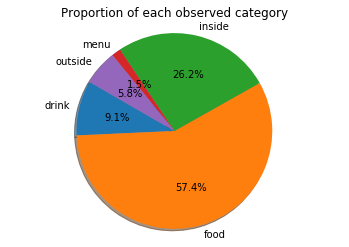

In [8]:
# Plot a pie chart to check proporation of each observed category

sizes = np.bincount(y)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=None, labels=class_names,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Proportion of each observed category')

plt.show()

## Model

In [35]:
bnmomemtum=0.9
def fire(x, squeeze, expand):
  y  = tf.keras.layers.Conv2D(filters=squeeze, kernel_size=1, activation='relu', padding='same')(x)
  y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
  y1 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=1, activation='relu', padding='same')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y1)
  y3 = tf.keras.layers.Conv2D(filters=expand//2, kernel_size=3, activation='relu', padding='same')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y3)
  return tf.keras.layers.concatenate([y1, y3])

def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

x = tf.keras.layers.Input(shape=[*IMAGE_SIZE, 3]) # input is 192x192 pixels RGB

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', use_bias=True, activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=bnmomemtum)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(64, 128)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(48, 96)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(5, activation='softmax')(y)

model = tf.keras.Model(x, y)

model.compile(
  optimizer='adam',
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 192, 192, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 192, 192, 32) 128         conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 192, 192, 24) 792         batch_normalization_32[0][0]     
____________________________________________________________________________________________

## Training

In [0]:
strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu)
tpu_model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

INFO:tensorflow:Querying Tensorflow master (grpc://192.168.43.2:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9395547180570580755)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 6367633851149154879)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 11596888001717943185)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 9183457543646557935)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 10822347198377972777)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

In [0]:
EPOCHS = 15

start_time = time.time()

history = tpu_model.fit(get_training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                          validation_data=get_validation_dataset, validation_steps=validation_steps)
end_time = time.time()
print("Time elapsed: ", end_time-start_time, " sec")

Epoch 1/15
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name=None), TensorSpec(shape=(128, 192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 5), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'beta_2': 0.9990000128746033, 'beta_1': 0.8999999761581421, 'epsilon': 1e-07, 'lr': 0.0010000000474974513, 'decay': 0.0, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for input_1
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7f9d324357f0> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 18.098301887512207 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU beta_2: 0.9990000128746033 {0.999}
INFO:tensorflow:CPU -> TPU beta_1: 0.899999976158142

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


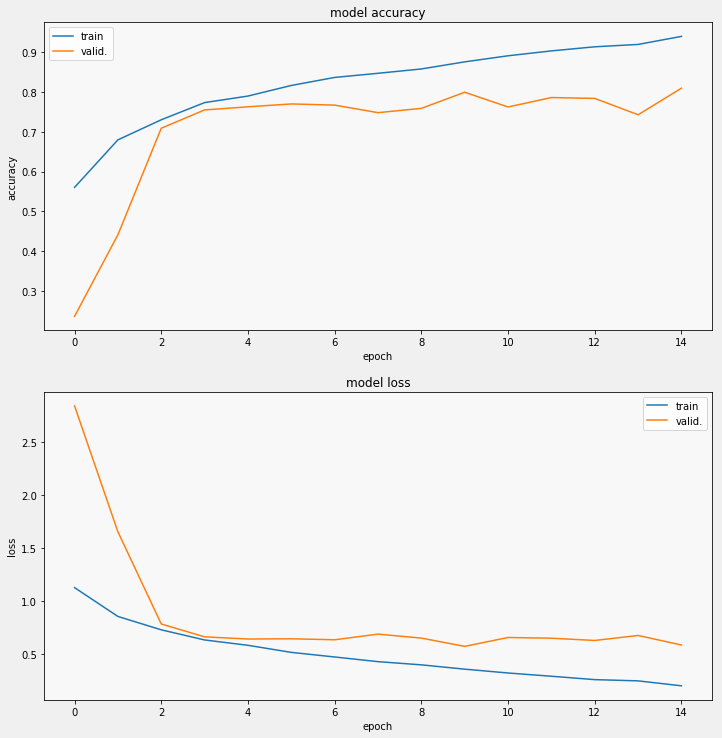

In [0]:
print(history.history.keys())
display_training_curves(history.history['acc'], history.history['val_acc'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)